In [ ]:
from collections import Counter
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
from tqdm import tqdm

In [ ]:
def get_nk_playlist_data(n = 10, stagger = 0):

    combined_data = []
    progress_bar = tqdm(total = n, desc = "Progress", ncols = 100)

    for i in range(n):
        i1 = stagger + i * 1000
        i2 = stagger + i * 1000 + 999
        filename = "Dataset/spotify_million_playlist_dataset/data/mpd.slice." + str(i1) + "-" + str(i2) + ".json"
        data = json.load(open(filename))
        for playlist in data["playlists"]:
            combined_data.append(playlist)
        progress_bar.update(1)
    progress_bar.close()

    return combined_data

In [ ]:
# Return a new dictionary with the keys typecasted as str
def convert_keys_to_str(D):
    return {str(k): v for k, v in D.items()}

# Return a new dictionary with the keys typecasted back to the original data type
def convert_keys_to_original(D):
    return {eval(k): v for k, v in D.items()}

In [ ]:
TRAIN_N_K = 1
train_data = get_nk_playlist_data(n = TRAIN_N_K)

Progress: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


In [ ]:
# Create a tracks dictionary and co-occurrence sparse matrix using the training data

tracks_dict = {}
tracks_fq = {}
co_occurrence = {}
idx = 1

progress_bar = tqdm(total = len(train_data), desc = "Progress", ncols = 100)

for playlist in train_data:

    playlist_track_ids = []
    for track in playlist['tracks']:
        if track['track_uri'] not in tracks_dict:
            tracks_dict[track['track_uri']] = idx
            tracks_fq[idx] = 1
            idx += 1
        else:
            tracks_fq[tracks_dict[track['track_uri']]] += 1
        playlist_track_ids.append(tracks_dict[track['track_uri']])

    for i in range(len(playlist_track_ids)):
        for j in range(i + 1, len(playlist_track_ids)):
            id_i = playlist_track_ids[i]
            id_j = playlist_track_ids[j]

            if id_i not in co_occurrence:
                co_occurrence[id_i] = {id_j: 1}
            elif id_j not in co_occurrence[id_i]:
                co_occurrence[id_i][id_j] = 1
            else:
                co_occurrence[id_i][id_j] += 1

            if id_j not in co_occurrence:
                co_occurrence[id_j] = {id_i: 1}
            elif id_i not in co_occurrence[id_j]:
                co_occurrence[id_j][id_i] = 1
            else:
                co_occurrence[id_j][id_i] += 1

    progress_bar.update(1)
progress_bar.close()

tracks_fq = dict(sorted(tracks_fq.items(), key=lambda item: item[1], reverse=True))
reverse_tracks_dict = {v: k for k, v in tracks_dict.items()}
top_500_tracks = list(tracks_fq.keys())[: 500]

Progress: 100%|████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 578.08it/s]


In [ ]:
def get_stratified_test_set_data(filename):

    stratified_data = []

    data = json.load(open(filename))
    for playlist in data["playlists"]:
        stratified_data.append(playlist)

    return stratified_data

In [ ]:
ordered_data = get_stratified_test_set_data(filename = "Dataset/test_set_1k_1k_26_90_unordered.json")

In [ ]:
# Stratified sampled data with 1000 playlists having 25 tracks provided

STRATIFIED_SIZE = 1000

ordered_tracks_x = []
stratified_pids = []
count = 0

progress_bar = tqdm(total = STRATIFIED_SIZE, desc = "Progress", ncols = 100)

for playlist in ordered_data:

    stratified_pids.append(playlist['pid'])
    x_list = []

    for i in range(len(playlist['tracks'])):
        track = playlist['tracks'][i]
        # Only accounting for the tracks in our training data - will have at least 23 tracks as THRESHOLD_PERC is 90
        if track['track_uri'] in tracks_dict:
            track_id = tracks_dict[track['track_uri']]
            x_list.append(track_id)
    ordered_tracks_x.append(x_list)

    progress_bar.update(1)
progress_bar.close()

Progress: 100%|██████████████████████████████████████████████| 1000/1000 [00:00<00:00, 38117.91it/s]


# Predict top 500 most frequent tracks

In [ ]:
# Make predictions on stratified sampled set

ordered_tracks_y_pred = []

progress_bar = tqdm(total = len(ordered_tracks_x), desc = "Progress", ncols = 100)

for i in range(len(ordered_tracks_x)):
    ordered_tracks_y_pred.append(top_500_tracks)

    progress_bar.update(1)
progress_bar.close()

Progress: 100%|█████████████████████████████████████████████| 1000/1000 [00:00<00:00, 999357.64it/s]


In [ ]:
# Write to json

ordered_dict = {}

ordered_tracks_y_pred_uris = [[reverse_tracks_dict[key] for key in inner_list] for inner_list in ordered_tracks_y_pred]

for i in range(len(stratified_pids)):
    ordered_dict[stratified_pids[i]] = ordered_tracks_y_pred_uris[i]

with open("pred_1k_1k_26_90_unordered_top_500.json", 'w') as pred_file:
    json.dump(ordered_dict, pred_file, indent = 4)

# Predict 500 random tracks

In [ ]:
# Make predictions on stratified sampled set

ordered_tracks_y_pred = []

progress_bar = tqdm(total = len(ordered_tracks_x), desc = "Progress", ncols = 100)

for i in range(len(ordered_tracks_x)):
    ordered_tracks_y_pred.append(random.sample(list(range(1, len(tracks_dict) + 1)), k = 500))

    progress_bar.update(1)
progress_bar.close()

Progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1263.33it/s]


In [ ]:
# Write to json

ordered_dict = {}

ordered_tracks_y_pred_uris = [[reverse_tracks_dict[key] for key in inner_list] for inner_list in ordered_tracks_y_pred]

for i in range(len(stratified_pids)):
    ordered_dict[stratified_pids[i]] = ordered_tracks_y_pred_uris[i]

with open("pred_1k_1k_26_90_unordered_random.json", 'w') as pred_file:
    json.dump(ordered_dict, pred_file, indent = 4)

# Check percentage of songs that are in top 500

In [ ]:
num_total = 0
num_top_500 = 0

progress_bar = tqdm(total = len(train_data), desc = "Progress", ncols = 100)

for playlist in train_data:

    for track in playlist['tracks']:
        if tracks_dict[track['track_uri']] in top_500_tracks:
            num_top_500 += 1
        num_total += 1

    progress_bar.update(1)
progress_bar.close()

Progress: 100%|███████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2390.62it/s]


In [ ]:
print(num_total)
print(num_top_500)
print(num_top_500 / num_total)

67503
9588
0.14203813163859383


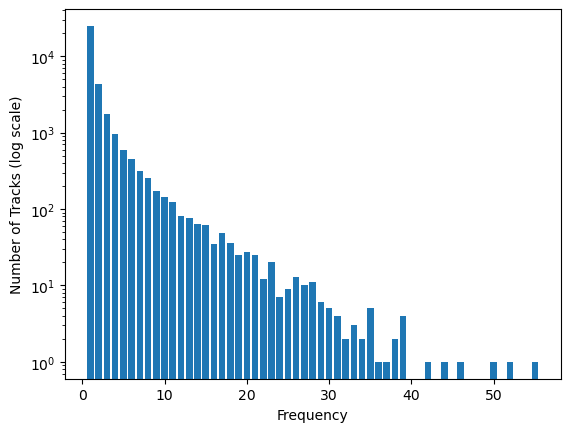

In [ ]:
# Count the frequency of each item
frequency_list = list(tracks_fq.values())
frequency = Counter(frequency_list)

# Sort items based on frequency
sorted_items = sorted(frequency.items(), key=lambda x: x[1], reverse=True)

# Separate items and their frequencies
items, counts = zip(*sorted_items)

# Plot frequency distribution
plt.bar(items, counts)
plt.xlabel('Frequency')
plt.ylabel('Number of Tracks (log scale)')
plt.yscale('log')
plt.show()

In [ ]:
print(frequency)

Counter({1: 24808, 2: 4283, 3: 1739, 4: 959, 5: 596, 6: 449, 7: 316, 8: 252, 9: 171, 10: 145, 11: 124, 12: 80, 13: 76, 14: 64, 15: 61, 17: 49, 18: 36, 16: 35, 20: 27, 21: 25, 19: 25, 23: 20, 26: 13, 22: 12, 28: 11, 27: 10, 25: 9, 24: 7, 29: 6, 35: 5, 30: 5, 39: 4, 31: 4, 33: 3, 38: 2, 34: 2, 32: 2, 55: 1, 52: 1, 50: 1, 46: 1, 44: 1, 42: 1, 37: 1, 36: 1})
